In [1]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score

# TASK 1

In [2]:
# 线性核
def linear_kernel(x1, x2):
    return np.inner(x1, x2)

# 多项式核
def poly_kernel(x1, x2, degree=4, c=1.0):
    return (np.inner(x1, x2) + c) ** degree

# 高斯核
def sqexp_kernel(x1, x2, l=0.5):
    return np.exp(-l * np.linalg.norm(x1 - x2) ** 2)

# 周期核
def periodic_kernel(x1, x2, p=2.0, l=3.0):
    return np.exp(-2 * (np.sin(np.pi * np.linalg.norm(x1 - x2) / p) ** 2) / (l ** 2))

# rbf核
def rbf_kernel(x1, x2, a=2, gamma=2):
    return a * np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

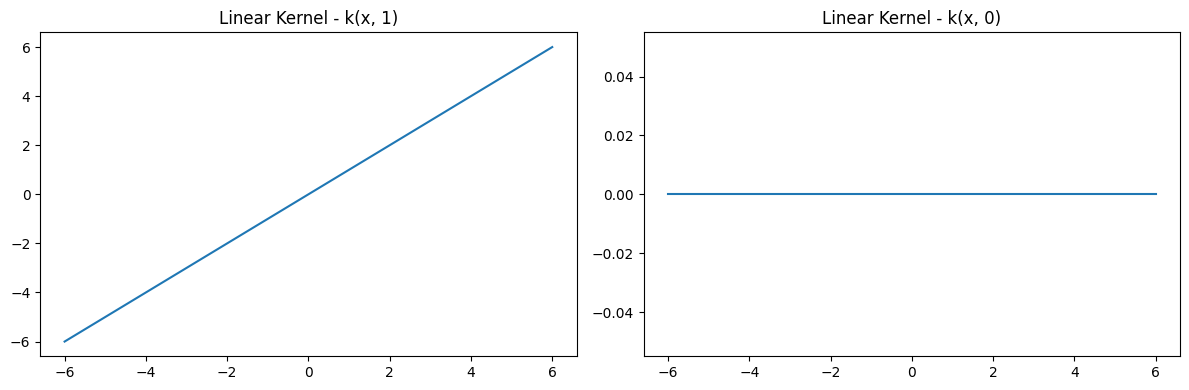

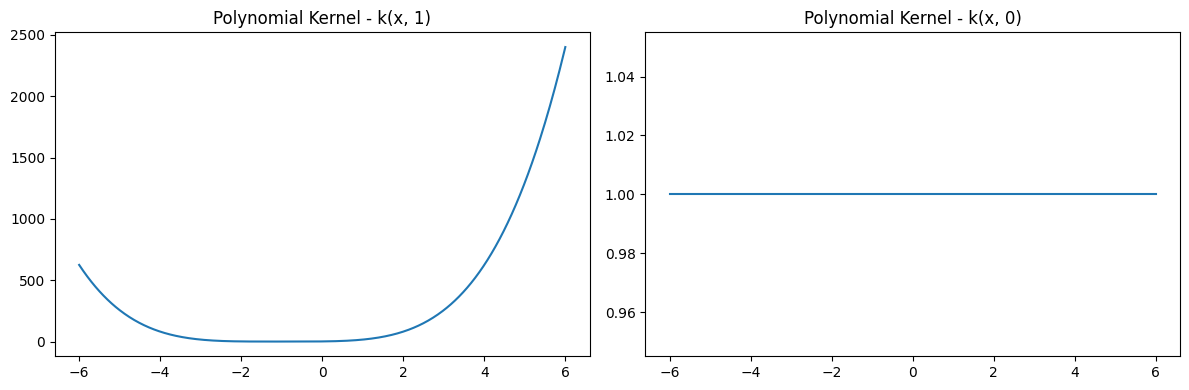

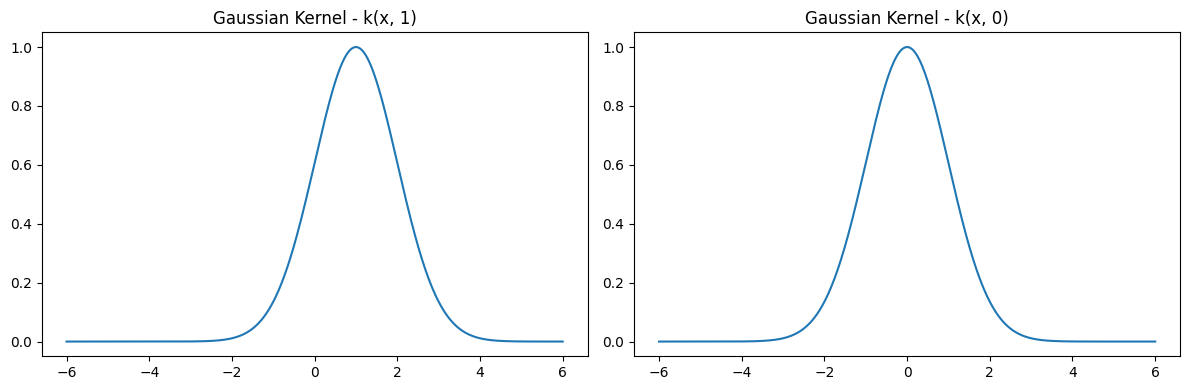

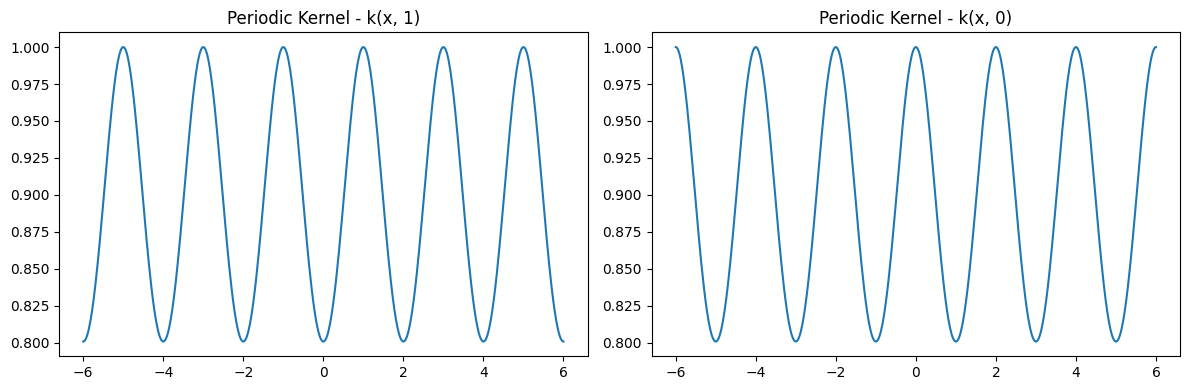

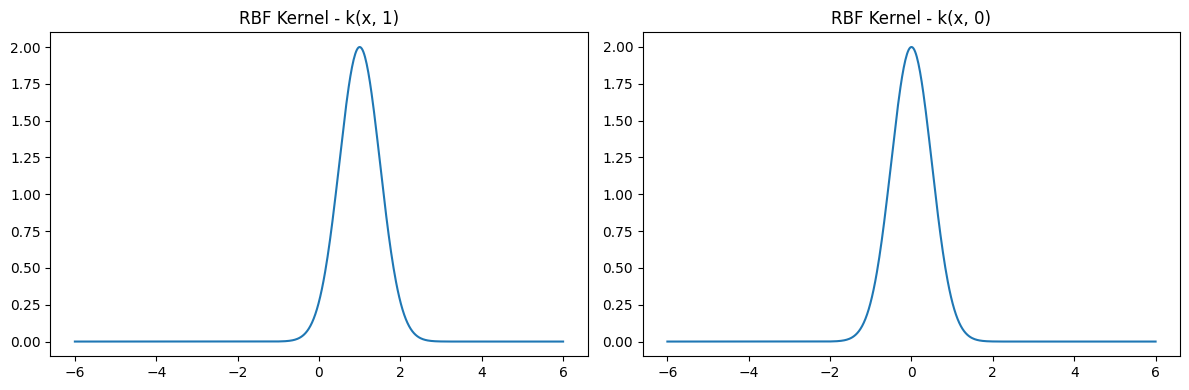

In [3]:
# x值的范围
x_values = np.linspace(-6, 6, 600)

# 计算并绘制 k(x, 1) 和 k(x, 0) 的图像
kernels = [linear_kernel, poly_kernel, sqexp_kernel, periodic_kernel, rbf_kernel]
kernel_names = ["Linear Kernel", "Polynomial Kernel", "Gaussian Kernel", "Periodic Kernel", "RBF Kernel"]

for kernel, kernel_name in zip(kernels, kernel_names):
    k_x_1 = [kernel(x, 1) for x in x_values]
    k_x_0 = [kernel(x, 0) for x in x_values]

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(x_values, k_x_1)
    plt.title(f'{kernel_name} - k(x, 1)')

    plt.subplot(122)
    plt.plot(x_values, k_x_0)
    plt.title(f'{kernel_name} - k(x, 0)')

    plt.tight_layout()
    plt.show()

# TASK 2

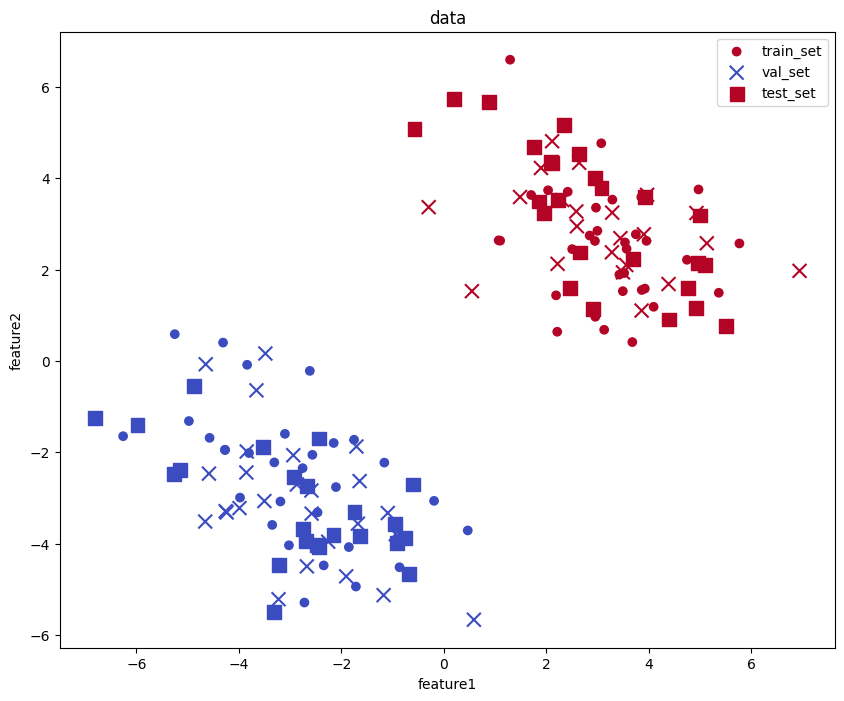

In [4]:
# 生成二维高斯
# 均值和协方差矩阵
mu1 = np.array([-3, -3])
mu2 = np.array([3, 3])
cov_matrix = np.array([[2, -1], [-1, 2]])

# 生成样本点
np.random.seed(0)

num_samples = 80
class1_samples = np.random.multivariate_normal(mu1, cov_matrix, num_samples)
class2_samples = np.random.multivariate_normal(mu2, cov_matrix, num_samples)

# 为每个类别添加标签
class1_labels = -np.ones(num_samples)  # -1 类别
class2_labels = np.ones(num_samples)   # +1 类别

# 将生成的样本点和标签合并
X = np.concatenate((class1_samples, class2_samples), axis=0)
y = np.concatenate((class1_labels, class2_labels), axis=0)

# X 包含样本点，y 包含对应的标签
# 划分数据集为训练集、验证集和测试集
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.6, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 绘制数据集
plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', label='train_set')
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='coolwarm', marker='x', s=100, label='val_set')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', marker='s', s=100, label='test_set')
plt.legend()
plt.title('data')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.show()

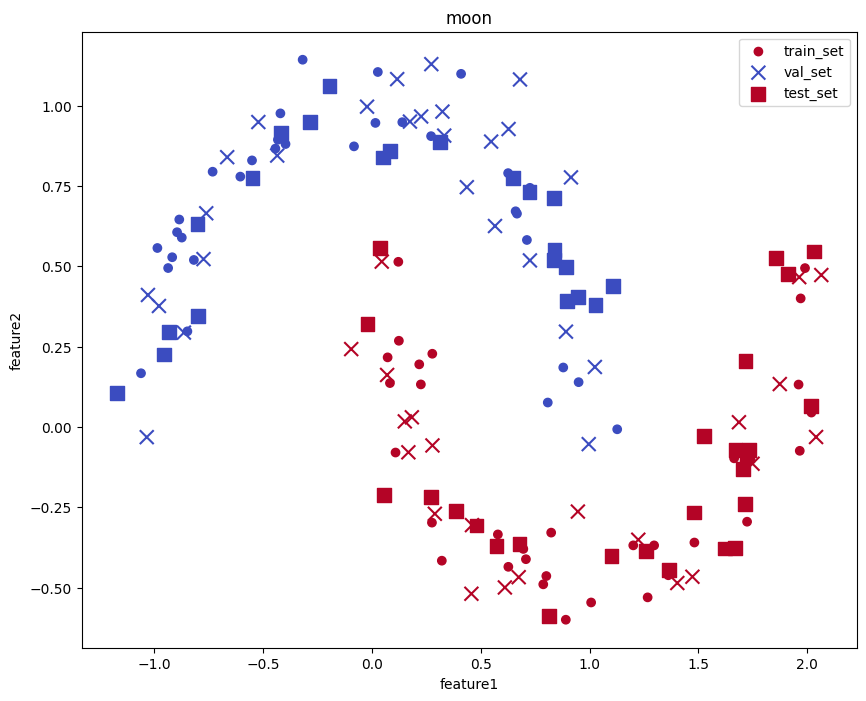

In [5]:
# 生成 moon 数据集
X_m, y_m = make_moons(n_samples=160, noise=0.1, random_state=42)

# 修改标签为 -1 和 1
y_m[y_m == 0] = -1
y_m = y_m.astype(float) # 一定要改成float，我要疯了

# 划分数据集为训练集、验证集和测试集
X_train_m, X_temp_m, y_train_m, y_temp_m = train_test_split(X_m, y_m, test_size=0.6, random_state=42)
X_val_m, X_test_m, y_val_m, y_test_m = train_test_split(X_temp_m, y_temp_m, test_size=0.5, random_state=42)

# 绘制数据集
plt.figure(figsize=(10, 8))
plt.scatter(X_train_m[:, 0], X_train_m[:, 1], c=y_train_m, cmap='coolwarm', label='train_set')
plt.scatter(X_val_m[:, 0], X_val_m[:, 1], c=y_val_m, cmap='coolwarm', marker='x', s=100, label='val_set')
plt.scatter(X_test_m[:, 0], X_test_m[:, 1], c=y_test_m, cmap='coolwarm', marker='s', s=100, label='test_set')
plt.legend()
plt.title('moon')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.show()

# TASK 3

In [6]:
def compute_kernel_matrix(X, kernel, **kwargs):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    if kernel == 'linear':
        K = linear_kernel(X, X)
    elif kernel == 'poly':
        K = poly_kernel(X, X)
    elif kernel == 'sqexp':
        K = rbf_kernel(X, X)
    elif kernel == 'periodic':
        K = periodic_kernel(X, X)
    elif kernel == 'rbf':
        K = rbf_kernel(X, X)
    return K

在QP这里纠结了很久，一开始使用自己生成的数据集能正常运行，但是换成moon就会报维度错误，最后发现是moon的label格式是int，应该统一改成float

In [7]:
def train_svm_with_kernel(X_train, y_train, kernel, **kwargs):
    # 计算 Gram 矩阵
    K = compute_kernel_matrix(X_train, kernel, **kwargs)

    # 定义 QP 问题的参数
    n_samples = X_train.shape[0]
    P = cvxopt.matrix(np.outer(y_train, y_train) * K)
    q = cvxopt.matrix(-np.ones(n_samples))
    G = cvxopt.matrix(np.diag(-np.ones(n_samples)))
    h = cvxopt.matrix(np.zeros(n_samples))
    A = cvxopt.matrix(y_train, (1, n_samples))
    b = cvxopt.matrix(0.0)

    # 解决 QP 问题
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # 提取拉格朗日乘子
    alphas = np.array(solution['x'])

    # 找到支持向量
    sv_indices = (alphas > 1e-4).flatten()
    sv_alphas = alphas[sv_indices]
    support_vectors = X_train[sv_indices]
    support_vector_labels = y_train[sv_indices]

    return sv_alphas, support_vectors, support_vector_labels

自己回想了一下其实使用jupyter notebook还是有方便，在改到心态要爆炸的时候去检查了各种数据和参数的输入输出格式，写代码顺畅很多QAQ

In [8]:
# 二维高斯数据集下的训练
sv_alphas_linear, support_vectors_linear, support_vector_labels_linear = train_svm_with_kernel(X_train, y_train, kernel='linear')
sv_alphas_poly, support_vectors_poly, support_vector_labels_poly = train_svm_with_kernel(X_train, y_train, kernel='poly')
sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp = train_svm_with_kernel(X_train, y_train, kernel='sqexp')
sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic = train_svm_with_kernel(X_train, y_train, kernel='periodic')
sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf = train_svm_with_kernel(X_train, y_train, kernel='rbf')

     pcost       dcost       gap    pres   dres
 0: -3.8112e+00 -5.8988e+00  1e+02  1e+01  2e+00
 1: -2.2371e+00 -5.5735e-01  1e+01  1e+00  1e-01
 2: -2.1294e-02 -2.1966e-01  2e-01  4e-16  4e-15
 3: -8.1151e-02 -1.1930e-01  4e-02  9e-17  9e-16
 4: -1.1165e-01 -1.1459e-01  3e-03  3e-17  5e-16
 5: -1.1398e-01 -1.1403e-01  5e-05  4e-17  5e-16
 6: -1.1402e-01 -1.1402e-01  5e-07  2e-17  5e-16
 7: -1.1402e-01 -1.1402e-01  5e-09  1e-17  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.3810e-01 -8.6382e-01  1e+02  9e+00  1e+00
 1: -1.0974e-01 -1.0525e-01  3e+00  3e-01  4e-02
 2: -1.7182e-02 -8.1917e-02  4e-01  3e-02  4e-03
 3: -2.7378e-02 -3.9646e-02  1e-01  7e-03  1e-03
 4: -2.3714e-02 -1.4038e-02  3e-02  2e-03  3e-04
 5: -1.0016e-02 -2.6216e-03  9e-03  5e-04  7e-05
 6: -4.1464e-03 -1.3122e-03  3e-03  2e-04  2e-05
 7: -9.2821e-04 -9.0901e-04  7e-04  2e-05  2e-06
 8: -7.8637e-04 -7.9649e-04  6e-05  1e-06  2e-07
 9: -7.8624e-04 -7.8833e-04  9e-06  2e-07  2e-0

In [9]:
# moon数据集下的训练
sv_alphas_linear_m, support_vectors_linear_m, support_vector_labels_linear_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='linear')
sv_alphas_polyr_m, support_vectors_poly_m, support_vector_labels_poly_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='poly')
sv_alphas_sqexp_m, support_vectors_sqexp_m, support_vector_labels_sqexp_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='sqexp')
sv_alphas_periodic_m, support_vectors_periodic_m, support_vector_labels_periodic_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='periodic')
sv_alphas_rbf_m, support_vectors_rbf_m, support_vector_labels_rbf_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='rbf')

     pcost       dcost       gap    pres   dres
 0: -2.1607e+01 -5.7895e+01  2e+02  1e+01  3e+00
 1: -8.3800e+01 -1.4988e+02  2e+02  7e+00  2e+00
 2: -4.1725e+02 -5.5455e+02  1e+02  5e+00  1e+00
 3: -1.1342e+03 -1.3493e+03  2e+02  5e+00  1e+00
 4: -7.3622e+03 -7.5428e+03  2e+02  4e+00  1e+00
 5: -2.3095e+05 -2.3252e+05  2e+03  4e+00  1e+00
 6: -2.6324e+07 -2.6367e+07  4e+04  4e+00  1e+00
 7: -1.4808e+10 -1.4811e+10  2e+06  4e+00  1e+00
 8: -1.2081e+11 -1.2082e+11  2e+07  4e+00  1e+00
 9: -1.2095e+11 -1.2096e+11  2e+07  4e+00  1e+00
10: -1.2164e+11 -1.2166e+11  2e+07  4e+00  1e+00
11: -1.2178e+11 -1.2180e+11  2e+07  4e+00  1e+00
12: -1.7537e+11 -1.7539e+11  3e+07  4e+00  1e+00
13: -3.7304e+11 -3.7310e+11  6e+07  4e+00  1e+00
14: -5.9551e+11 -5.9560e+11  9e+07  4e+00  1e+00
15: -1.2641e+12 -1.2642e+12  1e+08  4e+00  1e+00
Terminated (singular KKT matrix).
     pcost       dcost       gap    pres   dres
 0: -7.0839e+00 -1.5358e+01  2e+02  1e+01  2e+00
 1: -9.3467e+00 -1.1976e+01  6e+01  4

In [10]:
# 计算决策函数
def decision_function(X, alphas, support_vectors, support_vector_labels, kernel):
    result = np.sum(alphas * support_vector_labels * np.array([kernel(X, sv) for sv in support_vectors]))
    return result


# 绘制决策边界
def plot_decision_boundary(X, y, alphas, support_vector_labels, support_vectors, kernel, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array(
        [decision_function(point, alphas, support_vector_labels, support_vectors, kernel) for point in grid_points])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

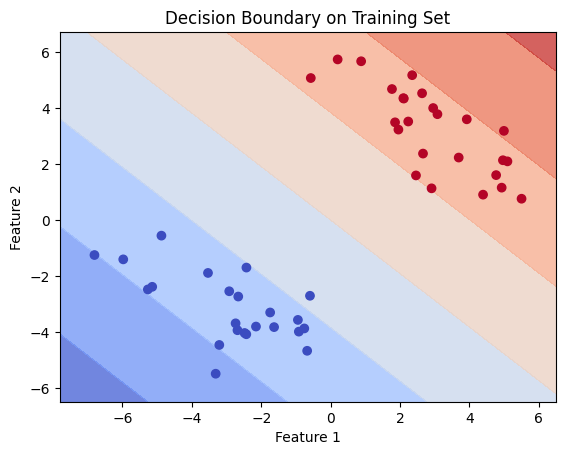

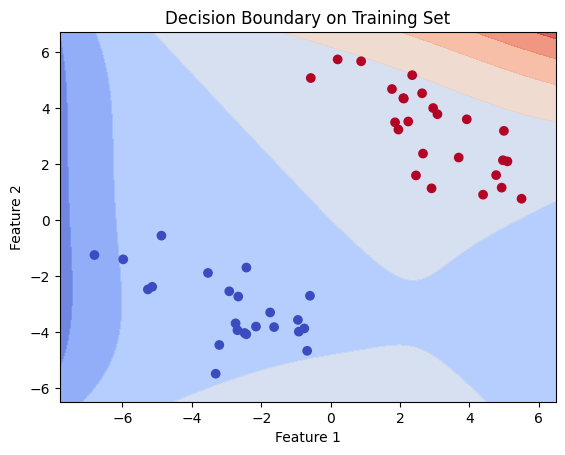

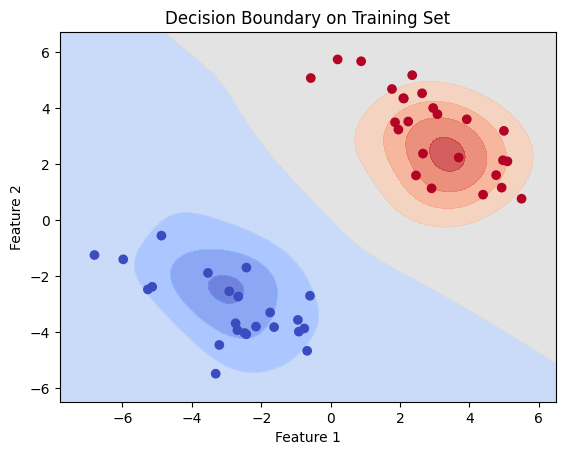

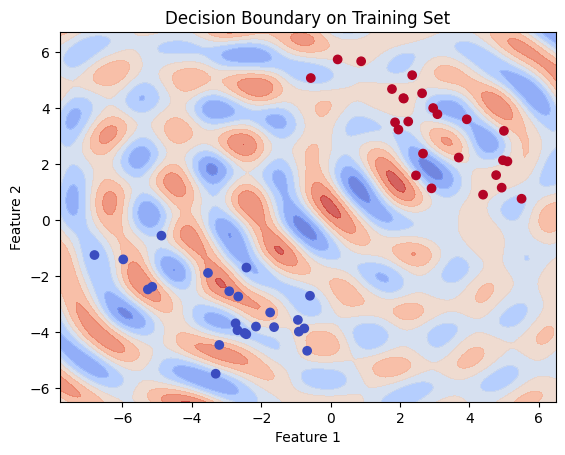

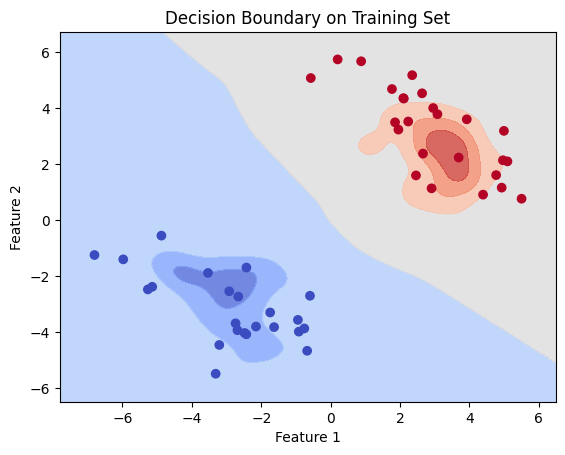

In [11]:
# 绘制二维高斯训练集上的决策边界
plot_decision_boundary(X_test, y_test, sv_alphas_linear, support_vectors_linear, support_vector_labels_linear, linear_kernel,'Decision Boundary on Training Set')
plot_decision_boundary(X_test, y_test, sv_alphas_poly, support_vectors_poly, support_vector_labels_poly, poly_kernel,'Decision Boundary on Training Set')
plot_decision_boundary(X_test, y_test, sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp, sqexp_kernel,'Decision Boundary on Training Set')
plot_decision_boundary(X_test, y_test, sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic, periodic_kernel,'Decision Boundary on Training Set')
plot_decision_boundary(X_test, y_test, sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf, rbf_kernel,'Decision Boundary on Training Set')

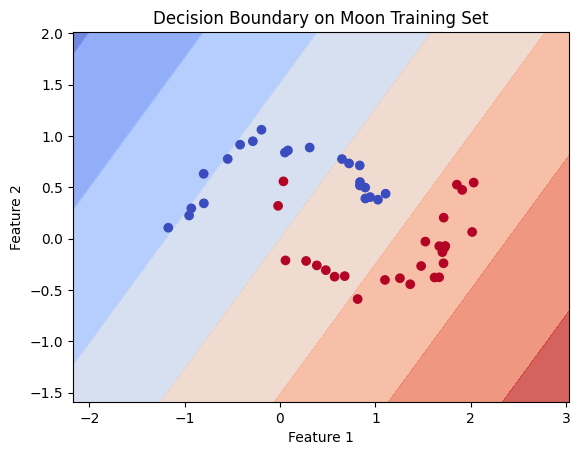

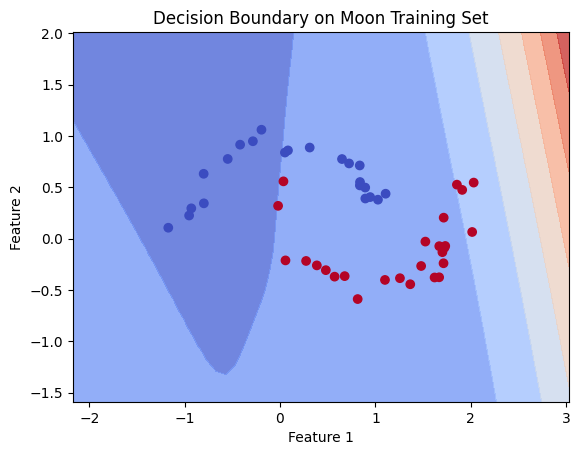

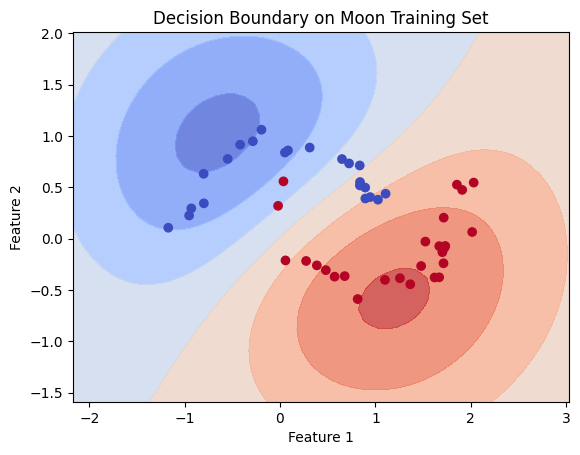

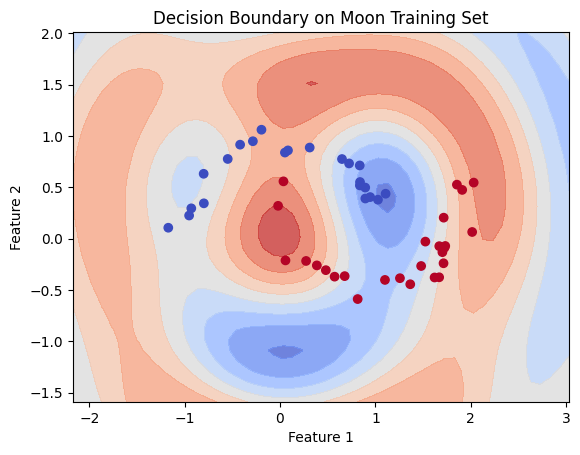

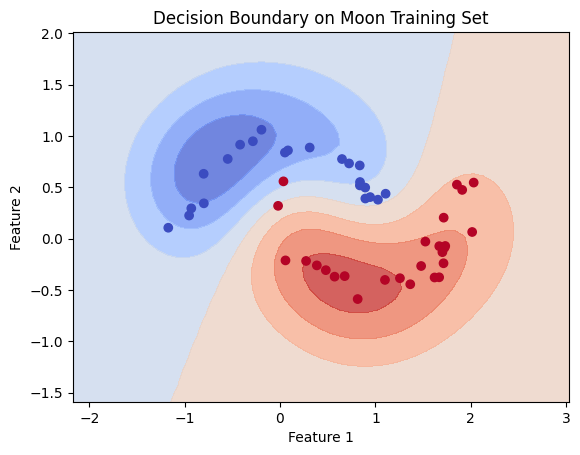

In [12]:
# 绘制moon数据集上的决策边界
plot_decision_boundary(X_test_m, y_test_m, sv_alphas_linear_m, support_vectors_linear_m, support_vector_labels_linear_m, linear_kernel, 'Decision Boundary on Moon Training Set')
plot_decision_boundary(X_test_m, y_test_m, sv_alphas_polyr_m, support_vectors_poly_m, support_vector_labels_poly_m, poly_kernel, 'Decision Boundary on Moon Training Set')
plot_decision_boundary(X_test_m, y_test_m, sv_alphas_sqexp_m, support_vectors_sqexp_m, support_vector_labels_sqexp_m, sqexp_kernel, 'Decision Boundary on Moon Training Set')
plot_decision_boundary(X_test_m, y_test_m, sv_alphas_periodic_m, support_vectors_periodic_m, support_vector_labels_periodic_m, periodic_kernel, 'Decision Boundary on Moon Training Set')
plot_decision_boundary(X_test_m, y_test_m, sv_alphas_rbf_m, support_vectors_rbf_m, support_vector_labels_rbf_m, rbf_kernel, 'Decision Boundary on Moon Training Set')

In [13]:
# 定义一组不同参数值
param_values_linear = {
    
}
param_values_poly = {
    'degree': [1, 3, 10],
    'c': [1, 2, 3]
}
param_values_sqexp = {
    'l': [0.1, 1,10]
}
param_values_periodic = {
    'p': [0.1, 1, 10],
    'l': [0.1, 1, 10]
}
param_values_rbf = {
    'a': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

去了解了grid search（Scikit-Learn GridSearchCV）后，原本打算把上面的函数全部封装起来，做成class SVM，然后调用grid search。
但是实际操作过程中发现API总是对不上，查找了很多办法最终没有成功。
根据grid search的原理，最后使用了相当笨重的for循环来解决问题

In [15]:
# 循环遍历不同的参数组合并设置核函数参数
K = linear_kernel(X_train, X_train)
sv_alphas_linear, support_vectors_linear, support_vector_labels_linear = train_svm_with_kernel(X_train, y_train, kernel='linear')
y_pred = np.array([decision_function(X_val[i],sv_alphas_linear, support_vectors_linear, support_vector_labels_linear, linear_kernel) for i in range(len(X_val))])
# 计算AUC
auc_linear = roc_auc_score(y_val, y_pred)
print("AUC_linear:", auc_linear)
        
for degree in param_values_poly['degree']:
    for c in param_values_poly['c']:
        poly_params = {'degree': degree, 'c': c}
        K = poly_kernel(X_train, X_train, degree, c)
        print(f"Setting Parameters (degree={degree}, c={c}): poly_params = {poly_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_poly, support_vectors_poly, support_vector_labels_poly = train_svm_with_kernel(X_train, y_train, kernel='poly', **poly_params)
        y_pred = np.array([decision_function(X_val[i],sv_alphas_poly, support_vectors_poly, support_vector_labels_poly, poly_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_poly = roc_auc_score(y_val, y_pred)
        print("AUC_poly:", auc_poly)
        
for l in param_values_sqexp['l']:
        sqexp_params = {'l': l}
        K = sqexp_kernel(X_train, X_train, l)
        print(f"Setting Parameters (l={l}): sqexp_params = {sqexp_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp = train_svm_with_kernel(X_train, y_train, kernel='sqexp', **sqexp_params)
        y_pred = np.array([decision_function(X_val[i],sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp, sqexp_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_sqexp = roc_auc_score(y_val, y_pred)
        print("AUC_sqexp:", auc_sqexp )
        
for p in param_values_periodic['p']:
    for l in param_values_periodic['l']:
        periodic_params = {'p': p, 'l': l}
        K = periodic_kernel(X_train, X_train, p, l)
        print(f"Setting Parameters (p={p}, l={l}): periodic_params = {periodic_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic = train_svm_with_kernel(X_train, y_train, kernel='periodic', **periodic_params)
        y_pred = np.array([decision_function(X_val[i],sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic, periodic_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_periodic = roc_auc_score(y_val, y_pred)
        print("AUC_rbf:", auc_periodic)
        
for a in param_values_rbf['a']:
    for gamma in param_values_rbf['gamma']:
        rbf_params = {'a': a, 'gamma': gamma}
        K = rbf_kernel(X_train, X_train, a, gamma)
        print(f"Setting Parameters (a={a}, gamma={gamma}): rbf_params = {rbf_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf = train_svm_with_kernel(X_train, y_train, kernel='rbf', **rbf_params)
        y_pred = np.array([decision_function(X_val[i],sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf, rbf_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_rbf = roc_auc_score(y_val, y_pred)
        print("AUC_rbf:", auc_rbf)

     pcost       dcost       gap    pres   dres
 0: -3.8112e+00 -5.8988e+00  1e+02  1e+01  2e+00
 1: -2.2371e+00 -5.5735e-01  1e+01  1e+00  1e-01
 2: -2.1294e-02 -2.1966e-01  2e-01  4e-16  4e-15
 3: -8.1151e-02 -1.1930e-01  4e-02  9e-17  9e-16
 4: -1.1165e-01 -1.1459e-01  3e-03  3e-17  5e-16
 5: -1.1398e-01 -1.1403e-01  5e-05  4e-17  5e-16
 6: -1.1402e-01 -1.1402e-01  5e-07  2e-17  5e-16
 7: -1.1402e-01 -1.1402e-01  5e-09  1e-17  5e-16
Optimal solution found.
AUC_linear: 1.0
Setting Parameters (degree=1, c=1): poly_params = {'degree': 1, 'c': 1}
     pcost       dcost       gap    pres   dres
 0: -6.3810e-01 -8.6382e-01  1e+02  9e+00  1e+00
 1: -1.0974e-01 -1.0525e-01  3e+00  3e-01  4e-02
 2: -1.7182e-02 -8.1917e-02  4e-01  3e-02  4e-03
 3: -2.7378e-02 -3.9646e-02  1e-01  7e-03  1e-03
 4: -2.3714e-02 -1.4038e-02  3e-02  2e-03  3e-04
 5: -1.0016e-02 -2.6216e-03  9e-03  5e-04  7e-05
 6: -4.1464e-03 -1.3122e-03  3e-03  2e-04  2e-05
 7: -9.2821e-04 -9.0901e-04  7e-04  2e-05  2e-06
 8: -7.8

AUC_rbf: 0.4318181818181818
Setting Parameters (p=0.1, l=10): periodic_params = {'p': 0.1, 'l': 10}
     pcost       dcost       gap    pres   dres
 0: -6.3937e+01 -1.2987e+02  7e+01  7e-16  2e+00
 1: -1.5648e+02 -1.5809e+02  2e+00  3e-15  1e+00
 2: -1.5332e+04 -1.5333e+04  2e+00  3e-13  1e+00
 3: -1.4722e+08 -1.4722e+08  2e+02  3e-09  1e+00
 4: -1.3079e+11 -1.3079e+11  1e+05  3e-06  1e+00
Terminated (singular KKT matrix).
AUC_rbf: 0.4318181818181818
Setting Parameters (p=1, l=0.1): periodic_params = {'p': 1, 'l': 0.1}
     pcost       dcost       gap    pres   dres
 0: -6.3937e+01 -1.2987e+02  7e+01  7e-16  2e+00
 1: -1.5648e+02 -1.5809e+02  2e+00  3e-15  1e+00
 2: -1.5332e+04 -1.5333e+04  2e+00  3e-13  1e+00
 3: -1.4722e+08 -1.4722e+08  2e+02  3e-09  1e+00
 4: -1.3079e+11 -1.3079e+11  1e+05  3e-06  1e+00
Terminated (singular KKT matrix).
AUC_rbf: 0.4318181818181818
Setting Parameters (p=1, l=1): periodic_params = {'p': 1, 'l': 1}
     pcost       dcost       gap    pres   dres
 0: -6

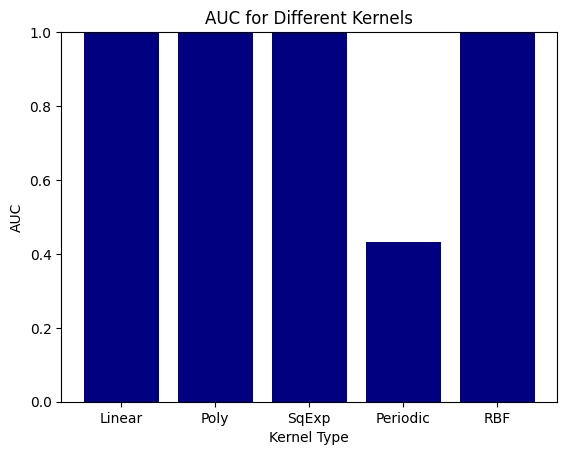

In [16]:
# AUC值
auc_values = [auc_linear, auc_poly, auc_sqexp, auc_periodic, auc_rbf]

# 核函数名称
kernel_names = ['Linear', 'Poly', 'SqExp', 'Periodic', 'RBF']

# 创建柱状图
plt.bar(kernel_names, auc_values, color='navy')
plt.xlabel('Kernel Type')
plt.ylabel('AUC')
plt.title('AUC for Different Kernels')
plt.ylim(0, 1)  # 设置y轴范围
plt.show()

In [17]:
# 换数据集moon
K = linear_kernel(X_train_m, X_train_m)
sv_alphas_linear_m, support_vectors_linear_m, support_vector_labels_linear_m = train_svm_with_kernel(X_train_m, y_train_m, kernel='linear')
y_pred_m = np.array([decision_function(X_val_m[i],sv_alphas_linear_m, support_vectors_linear_m, support_vector_labels_linear_m, linear_kernel) for i in range(len(X_val))])
# 计算AUC
auc_linear_m = roc_auc_score(y_val_m, y_pred_m)
print("AUC_linear:", auc_linear_m)
        
for degree in param_values_poly['degree']:
    for c in param_values_poly['c']:
        poly_params = {'degree': degree, 'c': c}
        K = poly_kernel(X_train_m, X_train_m, degree, c)
        print(f"Setting Parameters (degree={degree}, c={c}): poly_params = {poly_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_poly, support_vectors_poly, support_vector_labels_poly = train_svm_with_kernel(X_train_m, y_train_m, kernel='poly', **poly_params)
        y_pred_m = np.array([decision_function(X_val_m[i],sv_alphas_poly, support_vectors_poly, support_vector_labels_poly, poly_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_poly_m = roc_auc_score(y_val_m, y_pred_m)
        print("AUC_poly:", auc_poly_m)
        
for l in param_values_sqexp['l']:
        sqexp_params = {'l': l}
        K = sqexp_kernel(X_train_m, X_train_m, l)
        print(f"Setting Parameters (l={l}): sqexp_params = {sqexp_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp = train_svm_with_kernel(X_train_m, y_train_m, kernel='sqexp', **sqexp_params)
        y_pred_m = np.array([decision_function(X_val_m[i],sv_alphas_sqexp, support_vectors_sqexp, support_vector_labels_sqexp, sqexp_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_sqexp_m = roc_auc_score(y_val_m, y_pred_m)
        print("AUC_sqexp:", auc_sqexp_m)
        
for p in param_values_periodic['p']:
    for l in param_values_periodic['l']:
        periodic_params = {'p': p, 'l': l}
        K = periodic_kernel(X_train_m, X_train_m, p, l)
        print(f"Setting Parameters (p={p}, l={l}): periodic_params = {periodic_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic = train_svm_with_kernel(X_train_m, y_train_m, kernel='periodic', **periodic_params)
        y_pred_m = np.array([decision_function(X_val_m[i],sv_alphas_periodic, support_vectors_periodic, support_vector_labels_periodic, periodic_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_periodic_m = roc_auc_score(y_val_m, y_pred_m)
        print("AUC_rbf:", auc_periodic_m)
        
for a in param_values_rbf['a']:
    for gamma in param_values_rbf['gamma']:
        rbf_params = {'a': a, 'gamma': gamma}
        K = rbf_kernel(X_train_m, X_train_m, a, gamma)
        print(f"Setting Parameters (a={a}, gamma={gamma}): rbf_params = {rbf_params}")
        # 使用计算得到的 K 调用 train_svm_with_kernel 函数
        sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf = train_svm_with_kernel(X_train_m, y_train_m, kernel='rbf', **rbf_params)
        y_pred_m = np.array([decision_function(X_val_m[i],sv_alphas_rbf, support_vectors_rbf, support_vector_labels_rbf, rbf_kernel) for i in range(len(X_val))])
        # 计算AUC
        auc_rbf_m = roc_auc_score(y_val_m, y_pred_m)
        print("AUC_rbf:", auc_rbf_m)

     pcost       dcost       gap    pres   dres
 0: -2.1607e+01 -5.7895e+01  2e+02  1e+01  3e+00
 1: -8.3800e+01 -1.4988e+02  2e+02  7e+00  2e+00
 2: -4.1725e+02 -5.5455e+02  1e+02  5e+00  1e+00
 3: -1.1342e+03 -1.3493e+03  2e+02  5e+00  1e+00
 4: -7.3622e+03 -7.5428e+03  2e+02  4e+00  1e+00
 5: -2.3095e+05 -2.3252e+05  2e+03  4e+00  1e+00
 6: -2.6324e+07 -2.6367e+07  4e+04  4e+00  1e+00
 7: -1.4808e+10 -1.4811e+10  2e+06  4e+00  1e+00
 8: -1.2081e+11 -1.2082e+11  2e+07  4e+00  1e+00
 9: -1.2095e+11 -1.2096e+11  2e+07  4e+00  1e+00
10: -1.2164e+11 -1.2166e+11  2e+07  4e+00  1e+00
11: -1.2178e+11 -1.2180e+11  2e+07  4e+00  1e+00
12: -1.7537e+11 -1.7539e+11  3e+07  4e+00  1e+00
13: -3.7304e+11 -3.7310e+11  6e+07  4e+00  1e+00
14: -5.9551e+11 -5.9560e+11  9e+07  4e+00  1e+00
15: -1.2641e+12 -1.2642e+12  1e+08  4e+00  1e+00
Terminated (singular KKT matrix).
AUC_linear: 0.9090909090909092
Setting Parameters (degree=1, c=1): poly_params = {'degree': 1, 'c': 1}
     pcost       dcost       ga

AUC_rbf: 0.6870629370629371
Setting Parameters (p=1, l=0.1): periodic_params = {'p': 1, 'l': 0.1}
     pcost       dcost       gap    pres   dres
 0: -6.4000e+01 -1.2800e+02  6e+01  7e-16  2e+00
 1: -1.5904e+02 -1.6063e+02  2e+00  4e-15  1e+00
 2: -1.6060e+04 -1.6061e+04  2e+00  3e-13  1e+00
 3: -1.5902e+08 -1.5902e+08  2e+02  4e-09  1e+00
 4: -8.7295e+10 -8.7295e+10  1e+05  2e-06  1e+00
Terminated (singular KKT matrix).
AUC_rbf: 0.6870629370629371
Setting Parameters (p=1, l=1): periodic_params = {'p': 1, 'l': 1}
     pcost       dcost       gap    pres   dres
 0: -6.4000e+01 -1.2800e+02  6e+01  7e-16  2e+00
 1: -1.5904e+02 -1.6063e+02  2e+00  4e-15  1e+00
 2: -1.6060e+04 -1.6061e+04  2e+00  3e-13  1e+00
 3: -1.5902e+08 -1.5902e+08  2e+02  4e-09  1e+00
 4: -8.7295e+10 -8.7295e+10  1e+05  2e-06  1e+00
Terminated (singular KKT matrix).
AUC_rbf: 0.6870629370629371
Setting Parameters (p=1, l=10): periodic_params = {'p': 1, 'l': 10}
     pcost       dcost       gap    pres   dres
 0: -6.400

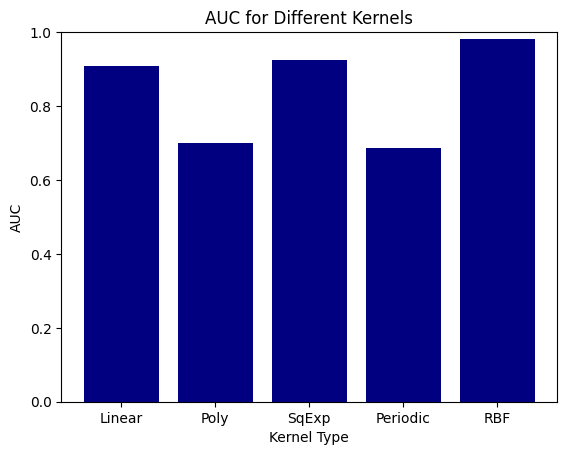

In [18]:
# AUC值
auc_values = [auc_linear_m, auc_poly_m, auc_sqexp_m, auc_periodic_m, auc_rbf_m]

# 核函数名称
kernel_names = ['Linear', 'Poly', 'SqExp', 'Periodic', 'RBF']

# 创建柱状图
plt.bar(kernel_names, auc_values, color='navy')
plt.xlabel('Kernel Type')
plt.ylabel('AUC')
plt.title('AUC for Different Kernels')
plt.ylim(0, 1)  # 设置y轴范围
plt.show()

下方代码为试图封装好class SVM来调用grid search的尝试之一。
先直接调用库函数，了解需要的输入输出以及数据格式，打印出结果。
查阅sklearn的相关文档后对自己上面的代码进行封装

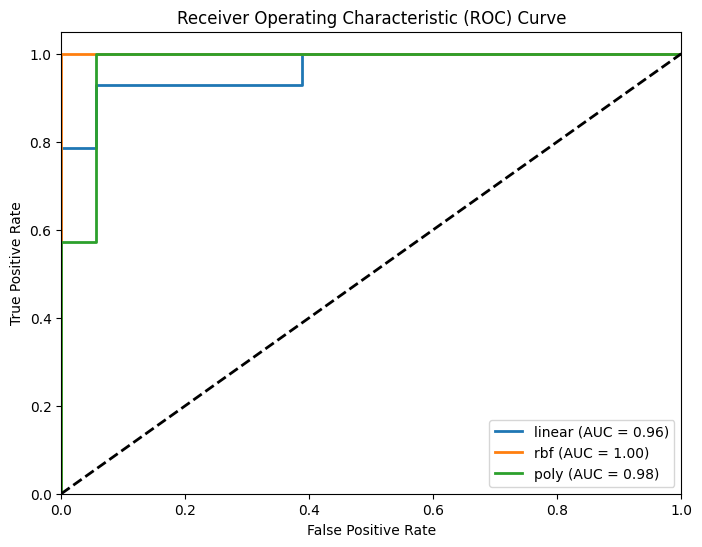

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# 准备数据集，加载Iris数据集作为示例
# 生成 moon 数据集
X, y = make_moons(n_samples=160, noise=0.1, random_state=42)

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 不同的核函数
kernels = ['linear', 'rbf', 'poly']

# 创建一个图形来绘制ROC曲线
plt.figure(figsize=(8, 6))

# 为每个核函数绘制ROC曲线
for kernel in kernels:
    classifier = SVC(kernel=kernel, probability=True)
    
    # 创建超参数字典
    param_grid = {
        'C': [0.1, 1, 10]
    }
    
    # 创建GridSearchCV对象
    grid_search = GridSearchCV(classifier, param_grid, cv=5)
    
    # 拟合GridSearchCV对象
    grid_search.fit(X_train, y_train)
    
    # 获取最佳模型
    best_model = grid_search.best_estimator_
    
    y_score = best_model.predict_proba(X_test)
    
    # 计算AUC
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])  # 二进制分类问题，我们关注类别1的概率
    
    # 绘制ROC曲线
    plt.plot(fpr, tpr, lw=2, label=f'{kernel} (AUC = {roc_auc_score(y_test, y_score[:, 1]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

下面是自己封装的结果，尝试了使用grid search

In [20]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_curve, roc_auc_score

import numpy as np
import cvxopt

# 线性核
def linear_kernel(x1, x2):
    return np.inner(x1, x2)

# 多项式核
def poly_kernel(x1, x2, degree=4, c=1.0):
    return (np.inner(x1, x2) + c) ** degree

# 高斯核
def sqexp_kernel(x1, x2, l=0.5):
    return np.exp(-l * np.linalg.norm(x1 - x2) ** 2)

# 周期核
def periodic_kernel(x1, x2, p=2.0, l=3.0):
    return np.exp(-2 * (np.sin(np.pi * np.linalg.norm(x1 - x2) / p) ** 2) / (l ** 2))

# rbf核
def rbf_kernel(x1, x2, a=2, gamma=2):
    return a * np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

class SVMClassifier:
    def __init__(self, kernel='linear', gamma = 1.0, **kwargs):
        self.kernel = kernel
        self.kwargs = kwargs
        self.gamma = gamma

    def fit(self, X_train, y_train):
        # 计算 Gram 矩阵
        K = self._compute_kernel_matrix(X_train)

        # 定义 QP 问题的参数
        n_samples = X_train.shape[0]
        P = cvxopt.matrix(np.outer(y_train, y_train) * K)
        q = cvxopt.matrix(-np.ones(n_samples))
        G = cvxopt.matrix(np.diag(-np.ones(n_samples)))
        h = cvxopt.matrix(np.zeros(n_samples))
        A = cvxopt.matrix(y_train, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # 解决 QP 问题
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # 提取拉格朗日乘子
        self.alphas = np.array(solution['x'])

        # 找到支持向量
        sv_indices = (self.alphas > 1e-4).flatten()
        sv_alphas = self.alphas[sv_indices]
        self.support_vectors = X_train[sv_indices]
        self.support_vector_labels = y_train[sv_indices]

    def _compute_kernel_matrix(self, X):
        if self.kernel == 'linear':
            return linear_kernel(X, X)
        elif self.kernel == 'poly':
            return poly_kernel(X, X, **self.kwargs)
        elif self.kernel == 'rbf':
            return rbf_kernel(X, X, **self.kwargs)
        else:
            raise ValueError("Unsupported kernel type")

    def decision_function(self, X):
        result = np.sum(self.alphas * self.support_vector_labels *
                        np.array([self._kernel_function(X, sv) for sv in self.support_vectors]))
        return result

    def _kernel_function(self, x1, x2):
        if self.kernel == 'linear':
            return np.inner(x1, x2)
        elif self.kernel == 'poly':
            degree = self.kwargs.get('degree', 3)
            gamma = self.kwargs.get('gamma', 1)
            coef0 = self.kwargs.get('coef0', 0)
            return (gamma * np.dot(x1, x2) + coef0) ** degree
        elif self.kernel == 'rbf':
            gamma = self.kwargs.get('gamma', 1)
            return np.exp(-gamma * np.linalg.norm(x1 - x2) ** 2)

    def predict(self, X_new):
        y_pre = self.decision_function(X_new)
        return y_pre

    def get_params(self, deep=True):
        """Get parameters for this estimator.

         Parameters
         ----------
         deep : boolean, optional
             If True, will return the parameters for this estimator and
             contained subobjects that are estimators.
            Returns
            -------
            params : mapping of string to any
                Parameter names mapped to their values.
            """

        out = dict()
        for key in ['kernel', 'gamma']:  # 这里是所用超参数的list
            value = getattr(self, key, None)
            if deep and hasattr(value, 'get_params'):
                deep_items = value.get_params().items()
                out.update((key + '__' + k, val) for k, val in deep_items)
            out[key] = value
        return out

    def set_params(self, **params):
        """Set the parameters of this estimator.

        The method works on simple estimators as well as on nested objects
        (such as pipelines). The latter have parameters of the form
        ``<component>__<parameter>`` so that it's possible to update each
        component of a nested object.

        Returns
        -------
        self
        """
        if not params:
            # Simple optimization to gain speed (inspect is slow)
            return self
        valid_params = self.get_params(deep=True)

        for key, value in params.items():
            if key not in valid_params:
                raise ValueError('Invalid parameter %s for estimator %s. '
                                 'Check the list of available parameters '
                                 'with `estimator.get_params().keys()`.' %
                                 (key, self))
            setattr(self, key, value)
            valid_params[key] = value

        return self


if __name__ == "__main__":
    # 示例用法
    # 生成 moon 数据集
    X_m, y_m = make_moons(n_samples=160, noise=0.1, random_state=42)

    # 修改标签为 -1 和 1
    y_m[y_m == 0] = -1
    y_m = y_m.astype(float)  

    # 划分数据集为训练集、验证集和测试集
    X_train_m, X_temp_m, y_train_m, y_temp_m = train_test_split(X_m, y_m, test_size=0.6, random_state=42)
    X_val_m, X_test_m, y_val_m, y_test_m = train_test_split(X_temp_m, y_temp_m, test_size=0.5, random_state=42)

    svm = SVMClassifier(kernel='rbf', gamma=0.1)
    svm.fit(X_train_m, y_train_m)

    decision_values = [svm.decision_function(x) for x in X_test_m]
    print(decision_values)

    # 定义参数网格
    param_grid = {
        'kernel': ['rbf'],
        'gamma': [0.1, 1, 10]
    }

    # 创建GridSearchCV对象
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

    # 执行网格搜索
    grid_search.fit(X_val_m, y_val_m)

    # 获取最佳参数
    best_params = grid_search.best_params_
    print("Best Parameters:", best_params)


     pcost       dcost       gap    pres   dres
 0: -6.4000e+01 -1.2800e+02  6e+01  2e-15  2e+00
 1: -1.5904e+02 -1.6063e+02  2e+00  3e-15  1e+00
 2: -1.6060e+04 -1.6061e+04  2e+00  3e-13  1e+00
 3: -1.5902e+08 -1.5902e+08  2e+02  4e-09  1e+00
 4: -8.2403e+10 -8.2404e+10  8e+04  2e-06  1e+00
Terminated (singular KKT matrix).
[902826660094.6261, 1193754224591.4055, 882701639831.3986, -260595943447.4088, -296010739012.30115, 260108626627.6151, 1046353316614.1697, -955190902753.5787, -640063008832.8168, -357803644032.0991, 1127245543749.4995, -1220469333731.1816, 502735436381.3811, 1153558416396.2034, -454564433347.93024, 706503408124.499, -796907633499.6222, -2199879789.7971582, 461160463239.6258, -990366551545.2942, 824384006770.8169, -1222092084017.4297, 945641977192.3036, 227371194197.03052, 1208731070069.4136, -946681600700.996, -721687646150.1663, 453706602591.14435, -1179369694156.578, -1270473341193.897, -1268169178246.0396, 1005386215205.6959, 306533349530.26, 951872396517.8315, 

D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
           ^^^^^^^^^^^^
  File "D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Programme\Anaconda3\envs\pytorch\Lib\site-packages\sklearn\utils\_param_validation.py", line 187, in w